Extracted files: ['H_ML_001_C_M_012_008.wav', 'NH_ML_002_N_M_014_052.wav', 'NH_ML_002_N_M_014_068.wav', 'H_ML_001_G_M_040_008.wav', 'H_ML_001_R_M_027_003.wav']
Unique class labels: ['C' 'G' 'N' 'P' 'R']


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2823 - loss: 76.4258 - val_accuracy: 0.2707 - val_loss: 1.5267
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 30s 675ms/step - accuracy: 0.3907 - loss: 1.5055 - val_accuracy: 0.5188 - val_loss: 1.2914
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 680ms/step - accuracy: 0.6644 - loss: 0.9420 - val_accuracy: 0.5789 - val_loss: 1.1188
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 712ms/step - accuracy: 0.8104 - loss: 0.6260 - val_accuracy: 0.5789 - val_loss: 1.1266
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 855ms/step - accuracy: 0.8337 - loss: 0.4560 - val_accuracy: 0.6241 - val_loss: 1.5847
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 603ms/step - accuracy: 0.9659 - loss: 0.0971 - val_accuracy: 0.6165 - val_loss: 1.6375
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 670ms/step - accuracy: 0.9877 - loss: 0.0594 - val_accuracy: 0.6241 - val_loss: 1.7109
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 530ms/step - accuracy: 0.9993 - loss: 0.0229 - val_accura

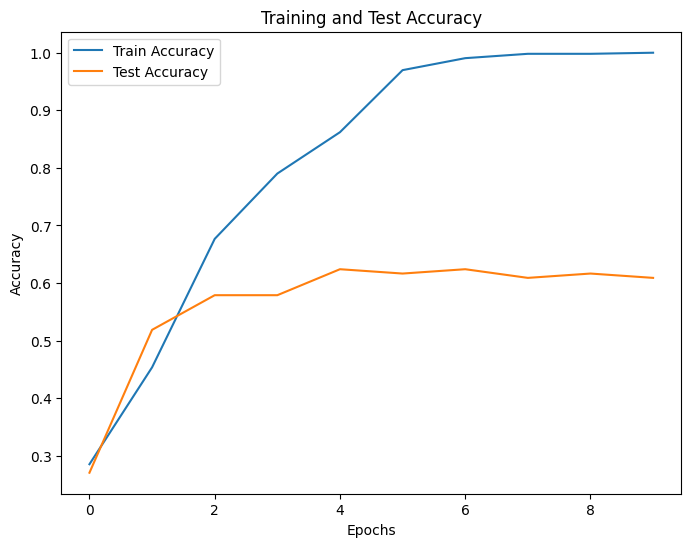

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
Classification Report:
              precision    recall  f1-score   support

           C       0.57      0.78      0.66        37
           G       0.40      0.17      0.24        12
           N       0.77      0.78      0.77        55
           P       0.36      0.27      0.31        15
           R       0.30      0.21      0.25        14

    accuracy                           0.61       133
   macro avg       0.48      0.44      0.45       133
weighted avg       0.58      0.61      0.59       133



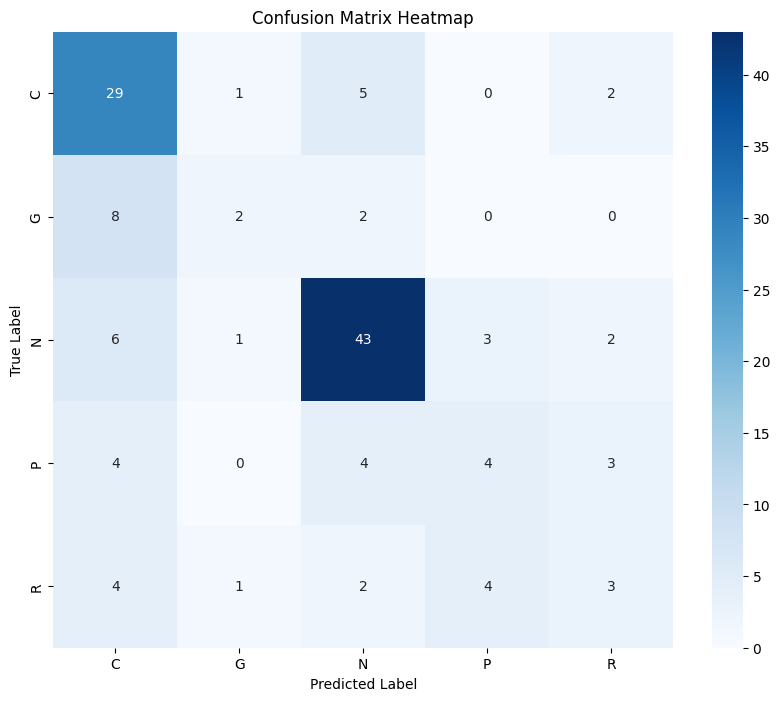

Macro F1-Score: 0.4454


In [14]:
import os
import librosa
import zipfile
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models

# Step 1: Define the path to the zip file and extract it
zip_file_path = '/content/drive/MyDrive/Dravidian-2025/Malayalam/Audio/Preprocessed audio/train_audio_preprocessed4.zip'
extracted_folder = '/content/drive/MyDrive/Dravidian-2025/Malayalam/Audio/Preprocessed audio/train_audio_preprocessed4'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Verify that the files have been extracted
extracted_files = os.listdir(extracted_folder)
print(f"Extracted files: {extracted_files[:5]}")  # Show first 5 files to confirm extraction

# Function to extract class from file name
def extract_class_from_file(file_name):
    parts = file_name.split('_')  # Split by underscores
    if len(parts) >= 4:
        class_label = parts[3]  # Extract the 4th part
        if class_label in ['G', 'P', 'R', 'C', 'N']:  # Add 'N' for non-hate categories
            return class_label
    return None  # Return None if the class cannot be determined

# Step 2: Extract features and labels from .wav files
labels = []
features = []

def extract_features(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)

    # Extract Mel spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr)

    # Log scaling of the Mel spectrogram for better visualization
    log_mel = librosa.power_to_db(mel, ref=np.max)

    return log_mel

# Extract features and labels from each file
for file_name in extracted_files:
    if file_name.endswith(".wav"):
        file_path = os.path.join(extracted_folder, file_name)
        class_label = extract_class_from_file(file_name)
        if class_label:  # Only process files with valid labels
            features.append(extract_features(file_path))
            labels.append(class_label)

# Convert features and labels to arrays
X = np.array(features)
y = np.array(labels)

# Check the unique labels
print(f"Unique class labels: {np.unique(y)}")

# Step 3: Encode Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Step 4: Reshape for CNN input
# Reshape data to (samples, height, width, channels) for CNN input
X = np.expand_dims(X, axis=-1)  # Add a channel dimension

# Step 5: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 6: Build the CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(np.unique(y)), activation='softmax')  # Output layer for classification
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 7: Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Step 8: Evaluate the Model
train_accuracy = history.history['accuracy'][-1]
test_accuracy = history.history['val_accuracy'][-1]

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title("Training and Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# Step 9: Predictions and Metrics
y_test_pred = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred, axis=1)  # Get the class with the highest probability

# Decode labels
y_test_actual = label_encoder.inverse_transform(y_test)
y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)

# Classification Report
print("Classification Report:")
print(classification_report(y_test_actual, y_test_pred_decoded))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_actual, y_test_pred_decoded, labels=label_encoder.classes_)

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Macro F1-Score
macro_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f"Macro F1-Score: {macro_f1:.4f}")


In [15]:
# Step 1: Define the path to the test zip file and extract it
test_zip_file_path = '/content/drive/MyDrive/Dravidian-2025/Malayalam/Audio/Preprocessed audio/finaled_test_audio_preprocessed4.zip'
test_extracted_folder = '/content/drive/MyDrive/Dravidian-2025/Malayalam/Audio/Preprocessed audio/test_audio'

# Extract the test zip file
with zipfile.ZipFile(test_zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(test_extracted_folder)

# Verify that the files have been extracted
test_extracted_files = os.listdir(test_extracted_folder)
print(f"Test extracted files: {test_extracted_files[:5]}")  # Show first 5 files to confirm extraction

# Step 2: Extract features and labels from test data
test_features = []
test_file_names = []  # To store file names for reference

for file_name in test_extracted_files:
    if file_name.endswith(".wav"):
        file_path = os.path.join(test_extracted_folder, file_name)
        test_features.append(extract_features(file_path))
        test_file_names.append(file_name)

# Convert test features to an array
X_test_final = np.array(test_features)

# Step 3: Reshape the test data for CNN input
X_test_final = np.expand_dims(X_test_final, axis=-1)  # Add a channel dimension

# Step 4: Perform predictions on the test data
y_test_pred_final = model.predict(X_test_final)
y_test_pred_final = np.argmax(y_test_pred_final, axis=1)  # Get the class with the highest probability

# Decode predicted labels
y_test_pred_decoded_final = label_encoder.inverse_transform(y_test_pred_final)

# Step 5: Save results to CSV
import pandas as pd

# Create a DataFrame with file names and predicted labels
results_df = pd.DataFrame({
    'File Name': test_file_names,
    'Predicted Label': y_test_pred_decoded_final
})

# Save to CSV
results_csv_path = '/content/drive/MyDrive/audio_cnn_predictions.csv'
results_df.to_csv(results_csv_path, index=False)

print(f"Predictions saved to {results_csv_path}")


Test extracted files: ['ML_TE_19.wav', 'ML_TE_39.wav', 'ML_TE_008.wav', 'ML_TE_34.wav', 'ML_TE_46.wav']
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Predictions saved to /content/drive/MyDrive/audio_cnn_predictions.csv
